In [41]:
import gensim
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [3]:
quora = pd.read_csv('quora.csv')
quora.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

len(vocab)

273056

In [5]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 50:
        filtered_vocab.add(word)

len(filtered_vocab)

14083

In [6]:
word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [7]:
id2word = {i:word for word, i in word2id.items()}

In [8]:
X = []

for text in quora.question_text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [9]:
MAX_LEN = max(len(x) for x in X)
MAX_LEN

134

In [22]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X.shape

(1306122, 134)

In [11]:
y = quora.target.values

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [13]:
def print_history(model):
    print(model.history.history.keys())
    plt.plot(model.history.history['root_mean_squared_error'])
    plt.plot(model.history.history['val_root_mean_squared_error'])
    plt.title('model RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.clf()

### Сложение

In [27]:
weights = np.zeros((len(word2id), 100))
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(
    input_dim=len(word2id), output_dim=100,
    trainable=False, weights=[weights]
)(inputs)
sum_ = tf.keras.layers.Lambda(
    lambda x: tf.keras.backend.sum(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(sum_)
dense = tf.keras.layers.Dense(64, activation='relu')(sum_)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model1 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

In [29]:
model1.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=30,
)

Epoch 1/30
2424/2424 [==============================] - 38s 16ms/step - loss: 0.1051 - root_mean_squared_error: 0.3242 - val_loss: 0.0972 - val_root_mean_squared_error: 0.3118
Epoch 2/30
2424/2424 [==============================] - 38s 16ms/step - loss: 0.0892 - root_mean_squared_error: 0.2986 - val_loss: 0.0840 - val_root_mean_squared_error: 0.2897
Epoch 3/30
2424/2424 [==============================] - 38s 16ms/step - loss: 0.0779 - root_mean_squared_error: 0.2791 - val_loss: 0.0747 - val_root_mean_squared_error: 0.2733
Epoch 4/30
2424/2424 [==============================] - 37s 15ms/step - loss: 0.0701 - root_mean_squared_error: 0.2648 - val_loss: 0.0685 - val_root_mean_squared_error: 0.2617
Epoch 5/30
2424/2424 [==============================] - 37s 15ms/step - loss: 0.0650 - root_mean_squared_error: 0.2549 - val_loss: 0.0645 - val_root_mean_squared_error: 0.2540
Epoch 6/30
2424/2424 [==============================] - 40s 16ms/step - loss: 0.0617 - root_mean_squared_error: 0.2484 -

KeyboardInterrupt: 

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


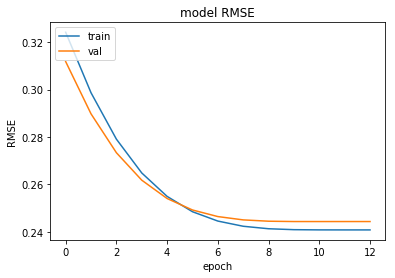

<Figure size 432x288 with 0 Axes>

In [30]:
print_history(model1)

В общем, модель перестала сходиться после 10-й эпохи, там лучший лосс

### Среднее

In [31]:
weights = np.zeros((len(word2id), 100))
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(
    input_dim=len(word2id), output_dim=100,
    trainable=False, weights=[weights]
)(inputs)
mean_ = tf.keras.layers.Lambda(
    lambda x: tf.keras.backend.sum(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(mean_)
dense = tf.keras.layers.Dense(64, activation='relu')(mean_)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

In [32]:
model2.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=30,
)

W0623 00:53:54.299911 139663435605824 network.py:957] Model was constructed with shape (None, 100) for input Tensor("input_6:0", shape=(None, 100), dtype=float32), but it was called on an input with incompatible shape (None, 134).
W0623 00:53:54.408986 139663435605824 network.py:957] Model was constructed with shape (None, 100) for input Tensor("input_6:0", shape=(None, 100), dtype=float32), but it was called on an input with incompatible shape (None, 134).


Epoch 1/30
2422/2424 [============================>.] - ETA: 0s - loss: 0.2252 - root_mean_squared_error: 0.4746

W0623 00:54:26.234723 139663435605824 network.py:957] Model was constructed with shape (None, 100) for input Tensor("input_6:0", shape=(None, 100), dtype=float32), but it was called on an input with incompatible shape (None, 134).


2424/2424 [==============================] - 33s 14ms/step - loss: 0.2252 - root_mean_squared_error: 0.4745 - val_loss: 0.2023 - val_root_mean_squared_error: 0.4498
Epoch 2/30
2424/2424 [==============================] - 35s 14ms/step - loss: 0.1821 - root_mean_squared_error: 0.4267 - val_loss: 0.1639 - val_root_mean_squared_error: 0.4049
Epoch 3/30
2424/2424 [==============================] - 33s 14ms/step - loss: 0.1476 - root_mean_squared_error: 0.3842 - val_loss: 0.1337 - val_root_mean_squared_error: 0.3657
Epoch 4/30
2424/2424 [==============================] - 32s 13ms/step - loss: 0.1209 - root_mean_squared_error: 0.3477 - val_loss: 0.1106 - val_root_mean_squared_error: 0.3326
Epoch 5/30
2424/2424 [==============================] - 33s 14ms/step - loss: 0.1007 - root_mean_squared_error: 0.3174 - val_loss: 0.0935 - val_root_mean_squared_error: 0.3058
Epoch 6/30
2424/2424 [==============================] - 33s 14ms/step - loss: 0.0860 - root_mean_squared_error: 0.2933 - val_loss: 

KeyboardInterrupt: 

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


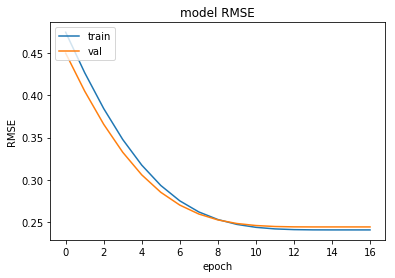

<Figure size 432x288 with 0 Axes>

In [33]:
print_history(model2)

Лосс прекратил отрицательный рост после 14-й эпохи

### Конкатенация

In [34]:
model3 = tf.keras.Sequential()

model3.add(tf.keras.layers.Embedding(
    input_dim=len(word2id),
    input_length=MAX_LEN, output_dim=100),
)
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(64, activation='relu'))
model3.add(tf.keras.layers.Dense(64, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3.compile(
    optimizer='adam',
    loss='mse',
    metrics=[
        tf.keras.metrics.RootMeanSquaredError()],
)

In [35]:
model3.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=30,
)

Epoch 1/30
2424/2424 [==============================] - 96s 40ms/step - loss: 0.0366 - root_mean_squared_error: 0.1913 - val_loss: 0.0357 - val_root_mean_squared_error: 0.1889
Epoch 2/30
2424/2424 [==============================] - 95s 39ms/step - loss: 0.0309 - root_mean_squared_error: 0.1759 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1875
Epoch 3/30
 127/2424 [>.............................] - ETA: 1:26 - loss: 0.0248 - root_mean_squared_error: 0.1574

KeyboardInterrupt: 

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


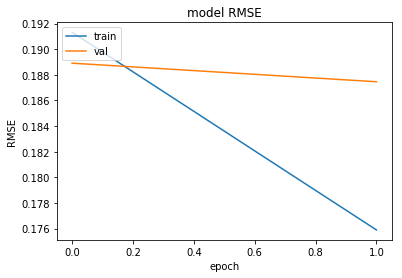

<Figure size 432x288 with 0 Axes>

In [36]:
print_history(model3)

К сожалению, моя `1050 Ti` это не тянет. Пока стоплю после второй эпохи, но результат мог быть лучше

# Двое эмбеддингов

In [40]:
corpus = quora.question_text.apply(preprocess).tolist()

In [43]:
w2v = gensim.models.Word2Vec(corpus)
ft = gensim.models.FastText(corpus)

In [44]:
def get_weights(model):
    weights = np.zeros((len(word2id), model.vector_size))
    for word, i in word2id.items():
        if word == 'PAD':
            continue
        if word == 'UNK':
            weights[i] = model.wv.get_vector("adopted") 
        try:
            weights[i] = model.wv.get_vector(word)
        except KeyError:
            weights[i] = model.wv.get_vector("adopted") 
    return weights

In [45]:
ft_weights = get_weights(ft)
w2v_weights = get_weights(w2v)

In [52]:
embed = lambda w: tf.keras.layers.Embedding(
    input_dim=len(word2id), output_dim=100,
    trainable=False, weights=[w])(inputs)

In [53]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Concatenate()([
    embed(ft_weights),
    embed(w2v_weights),
])
transformed = tf.keras.layers.Flatten()(embeddings)

dense = tf.keras.layers.Dense(64, activation="relu")(transformed)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(dense)
model4 = tf.keras.Model(inputs=inputs, outputs=outputs)
model4.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [54]:
model4.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=30,
)

Epoch 1/30
2424/2424 [==============================] - 67s 28ms/step - loss: 0.1409 - accuracy: 0.9460 - val_loss: 0.1379 - val_accuracy: 0.9463
Epoch 2/30
2424/2424 [==============================] - 68s 28ms/step - loss: 0.1297 - accuracy: 0.9496 - val_loss: 0.1358 - val_accuracy: 0.9468
Epoch 3/30
2424/2424 [==============================] - 67s 28ms/step - loss: 0.1249 - accuracy: 0.9514 - val_loss: 0.1357 - val_accuracy: 0.9471
Epoch 4/30
2424/2424 [==============================] - 68s 28ms/step - loss: 0.1205 - accuracy: 0.9530 - val_loss: 0.1354 - val_accuracy: 0.9474
Epoch 5/30
2424/2424 [==============================] - 69s 29ms/step - loss: 0.1161 - accuracy: 0.9547 - val_loss: 0.1368 - val_accuracy: 0.9469
Epoch 6/30
2424/2424 [==============================] - 69s 28ms/step - loss: 0.1115 - accuracy: 0.9563 - val_loss: 0.1399 - val_accuracy: 0.9468
Epoch 7/30
2424/2424 [==============================] - 70s 29ms/step - loss: 0.1072 - accuracy: 0.9581 - val_loss: 0.1428 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


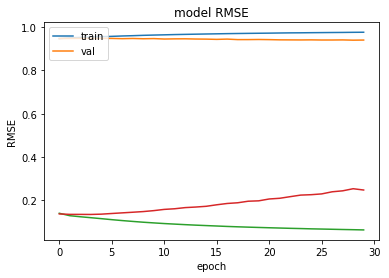

<Figure size 432x288 with 0 Axes>

In [59]:
print(model4.history.history.keys())
plt.plot(model4.history.history['accuracy'])
plt.plot(model4.history.history['val_accuracy'])
plt.plot(model4.history.history['loss'])
plt.plot(model4.history.history['val_loss'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.clf()

Отрицательный рост лосса продлился даже после 30-ти эпох. Но, судя по графику, получилась что-то так себе